## Pathological Myopia Detection Using Fundus Images

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/sabahat/.local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Image Processing Libraries
from tqdm import tqdm  # to show processing bar
from skimage.io import imread, imshow
from skimage.transform import resize

In [3]:
''' Standard Size of Images '''
img_width = 128 
img_hight = 128
img_channels = 3
# adjust randome seed size
seed = 42
np.random.seed = seed

##  Data Preprocessing

Resizing Training Images

In [31]:
'''  
Data Preprocessing
''' 
train_path = 'AllFundusPPA/'
test_path = 'Validation/'
train_ids = next(os.walk(train_path))[2]#next return a tuple(all folders at 1 position
# test_ids = next(os.walk(test_path))[2]
# print(len(train_ids))
# print(len(test_ids))
X_train = np.zeros((len(train_ids),img_hight, img_width, img_channels), dtype=np.uint8)
# X_train.shape
Y_train = np.zeros((len(train_ids),img_hight, img_width, 1), dtype=np.bool) # for Masks
# Y_train.shape
#
""" Resizing Training Images  """
#
masks_path = next(os.walk('PPAMaskCreation/'))[2]
# print(masks_path)
training_ids = sorted(train_ids)
masks_ids = sorted(masks_path)
indx = 0
print('Resizing Training Images and Masks')
for img_id in tqdm(training_ids):
    image = imread(train_path+img_id)[:,:,:img_channels]
    image = resize(image, (img_hight, img_width), mode='constant', preserve_range= True)
    X_train[indx] = image # fill empty X_train with values from images
    mask = np.zeros((img_hight, img_width, 1), dtype=np.bool)
#     for mask_file in next(os.walk(path+'/masks/'))[2]:
    test_mask = imread('PPAMaskCreation/'+masks_ids[indx])
    test_mask = np.expand_dims(resize(test_mask,(img_hight, img_width), mode='constant', preserve_range=True), axis=-1)#
#     mask = np.maximum(mask, test_mask)
    Y_train[indx] = test_mask
    indx += 1 



  1%|          | 2/311 [00:00<00:17, 17.97it/s]

Resizing Training Images and Masks


100%|██████████| 311/311 [00:04<00:00, 64.13it/s]


In [5]:
test_path = 'Validation/'
test_path = next(os.walk('Validation/'))[2]
test_ids = sorted(test_path)
# print(test_ids)

Resizing Test Images

In [6]:
model1 = tf.keras.models.load_model('saved_model/my_model')

In [7]:
# Check its architecture
model1.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [8]:
X_test = np.zeros((len(test_ids),img_hight, img_width, img_channels), dtype=np.uint8)
def predict(image):
    X_Ttest = np.zeros((1,img_hight, img_width, img_channels), dtype=np.uint8)
    #image = imread(file_name)
    image1 = resize(image, (img_hight, img_width), mode='constant', preserve_range=True)
    X_Ttest = np.reshape(image1, X_Ttest.shape)

    # Predicting
    predicted_valid = model1.predict(X_Ttest, verbose=1)
    preds_valid_t = (predicted_valid > 0.5).astype(np.uint8) # ceil the values(if > 0.5 then convert to 1)
    pred_img =  np.squeeze(preds_valid_t) # convert (1,128,128,1) to (128,128)
    return pred_img

In [9]:
import cv2
import matplotlib.pyplot as plt
#X_test = np.zeros((len(test_ids),img_hight, img_width, img_channels), dtype=np.uint8)
# X_test.shape
sizes_test = []
#print('Resizing Test Images...')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path =  'Validation/' + id_
    image = imread(path)[:,:,:img_channels]
    rgbimg=image
    sizes_test.append([image.shape[0], image.shape[1]])
    img = predict(image) # predicting mask from model
    for x in range (128):
        for y in range (128):
            if img[y,x]==0 :
               # print('yes')
                img[y,x]=0
            elif img[y,x]==1 :
               # print("no")
                img[y,x]=255
    imgmask=img
    imgmask=cv2.resize(imgmask,(128,128))
    rgbmask = image
    rgbmask=cv2.resize(rgbmask,(128,128))
    for x in range (128):
        for y in range (128):
            if imgmask[y,x]==255 :
               # print('yes')
                rgbmask[y,x]=255
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    #imshow(img) # showing image
    #plt.show()
    #print("h",img.shape)
    img=cv2.resize(img,(400,400))
    #print("shape",img.shape)
    ret,thresh = cv2.threshold(img,120,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    cnt = contours[0]
    M = cv2.moments(cnt)
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    radius += 20
    for i in range(1,radius):
        img = cv2.circle(img,center,radius-i,(0,255,0),85)
    # print(radius)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray=cv2.resize(gray,(400,400))
    #print("gshape",gray.shape)
    fimg = cv2.bitwise_or(gray,img)
    fimg=cv2.resize(fimg,(128,128))
    rgbimg=cv2.resize(rgbimg,(128,128))
    rgbmask = cv2.cvtColor(rgbmask,cv2.COLOR_RGB2GRAY)
    #fimg=cv2.bitwise_xor(fimg,rgbmask)
    for x in range (128):
        for y in range (128):
            if rgbmask[y,x]!=255 :
               # print('yes')
                fimg[y,x]=255
    for x in range (128):
        for y in range (128):
            if fimg[y,x]==255 :
               # print('yes')
                rgbimg[y,x]=255
                #predimg[y,x]=255
           # elif fimg[y,x]<255 :
               # print("no")
            #    rgbimg[y,x]=rgbimg[y,x]
                #predimg[y,x]=255
    #print("fshape",fimg.shape)
    #print("tshape",X_test[n].shape)
    #fimg = cv2.cvtColor(fimg,cv2.COLOR_GRAY2RGB)
    image1 = resize(rgbimg, (img_hight, img_width), mode='constant', preserve_range=True)
    #image1 = resize(fimg, (img_hight, img_width), mode='constant', preserve_range=True)
    X_test[n] = image1
#print('Resizing Done!!!')

  0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 345ms/sample


  0%|          | 1/400 [00:02<15:18,  2.30s/it]

1/1 [==============================] - 0s 34ms/sample


  0%|          | 2/400 [00:04<14:28,  2.18s/it]

1/1 [==============================] - 0s 36ms/sample


  1%|          | 3/400 [00:06<13:58,  2.11s/it]

1/1 [==============================] - 0s 38ms/sample


  1%|          | 4/400 [00:08<14:25,  2.19s/it]

1/1 [==============================] - 0s 32ms/sample


  1%|▏         | 5/400 [00:10<14:03,  2.14s/it]

1/1 [==============================] - 0s 32ms/sample


  2%|▏         | 6/400 [00:12<13:41,  2.08s/it]

1/1 [==============================] - 0s 43ms/sample


  2%|▏         | 7/400 [00:14<13:39,  2.08s/it]

1/1 [==============================] - 0s 39ms/sample


  2%|▏         | 8/400 [00:16<13:09,  2.01s/it]

1/1 [==============================] - 0s 62ms/sample


  2%|▏         | 9/400 [00:18<13:07,  2.01s/it]

1/1 [==============================] - 0s 34ms/sample


  2%|▎         | 10/400 [00:20<13:05,  2.01s/it]

1/1 [==============================] - 0s 35ms/sample


  3%|▎         | 11/400 [00:21<11:22,  1.75s/it]

1/1 [==============================] - 0s 32ms/sample


  3%|▎         | 12/400 [00:23<11:38,  1.80s/it]

1/1 [==============================] - 0s 32ms/sample


  3%|▎         | 13/400 [00:25<11:36,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


  4%|▎         | 14/400 [00:27<11:40,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


  4%|▍         | 15/400 [00:29<11:44,  1.83s/it]

1/1 [==============================] - 0s 31ms/sample


  4%|▍         | 16/400 [00:30<11:43,  1.83s/it]

1/1 [==============================] - 0s 45ms/sample


  4%|▍         | 17/400 [00:32<12:01,  1.88s/it]

1/1 [==============================] - 0s 31ms/sample


  4%|▍         | 18/400 [00:34<12:09,  1.91s/it]

1/1 [==============================] - 0s 38ms/sample


  5%|▍         | 19/400 [00:36<12:16,  1.93s/it]

1/1 [==============================] - 0s 31ms/sample


  5%|▌         | 20/400 [00:38<12:07,  1.91s/it]

1/1 [==============================] - 0s 31ms/sample


  5%|▌         | 21/400 [00:40<11:47,  1.87s/it]

1/1 [==============================] - 0s 31ms/sample


  6%|▌         | 22/400 [00:42<11:45,  1.87s/it]

1/1 [==============================] - 0s 31ms/sample


  6%|▌         | 23/400 [00:44<11:44,  1.87s/it]

1/1 [==============================] - 0s 31ms/sample


  6%|▌         | 24/400 [00:46<11:39,  1.86s/it]

1/1 [==============================] - 0s 32ms/sample


  6%|▋         | 25/400 [00:47<11:31,  1.84s/it]

1/1 [==============================] - 0s 31ms/sample


  6%|▋         | 26/400 [00:49<11:34,  1.86s/it]

1/1 [==============================] - 0s 34ms/sample


  7%|▋         | 27/400 [00:51<11:35,  1.86s/it]

1/1 [==============================] - 0s 31ms/sample


  7%|▋         | 28/400 [00:53<11:33,  1.87s/it]

1/1 [==============================] - 0s 31ms/sample


  7%|▋         | 29/400 [00:55<11:23,  1.84s/it]

1/1 [==============================] - 0s 32ms/sample


  8%|▊         | 30/400 [00:57<11:19,  1.84s/it]

1/1 [==============================] - 0s 32ms/sample


  8%|▊         | 31/400 [00:58<11:15,  1.83s/it]

1/1 [==============================] - 0s 31ms/sample


  8%|▊         | 32/400 [01:00<11:14,  1.83s/it]

1/1 [==============================] - 0s 31ms/sample


  8%|▊         | 33/400 [01:02<11:08,  1.82s/it]

1/1 [==============================] - 0s 31ms/sample


  8%|▊         | 34/400 [01:04<11:10,  1.83s/it]

1/1 [==============================] - 0s 31ms/sample


  9%|▉         | 35/400 [01:06<11:12,  1.84s/it]

1/1 [==============================] - 0s 33ms/sample


  9%|▉         | 36/400 [01:07<09:36,  1.58s/it]

1/1 [==============================] - 0s 32ms/sample


  9%|▉         | 37/400 [01:09<10:05,  1.67s/it]

1/1 [==============================] - 0s 31ms/sample


 10%|▉         | 38/400 [01:10<10:20,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 10%|▉         | 39/400 [01:12<10:33,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 10%|█         | 40/400 [01:14<10:41,  1.78s/it]

1/1 [==============================] - 0s 47ms/sample


 10%|█         | 41/400 [01:16<10:48,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 10%|█         | 42/400 [01:18<10:44,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 11%|█         | 43/400 [01:20<10:47,  1.81s/it]

1/1 [==============================] - 0s 49ms/sample


 11%|█         | 44/400 [01:21<09:07,  1.54s/it]

1/1 [==============================] - 0s 31ms/sample


 11%|█▏        | 45/400 [01:22<09:34,  1.62s/it]

1/1 [==============================] - 0s 31ms/sample


 12%|█▏        | 46/400 [01:24<09:45,  1.65s/it]

1/1 [==============================] - 0s 31ms/sample


 12%|█▏        | 47/400 [01:25<08:26,  1.44s/it]

1/1 [==============================] - 0s 31ms/sample


 12%|█▏        | 48/400 [01:27<09:00,  1.54s/it]

1/1 [==============================] - 0s 31ms/sample


 12%|█▏        | 49/400 [01:29<09:28,  1.62s/it]

1/1 [==============================] - 0s 30ms/sample


 12%|█▎        | 50/400 [01:30<09:47,  1.68s/it]

1/1 [==============================] - 0s 30ms/sample


 13%|█▎        | 51/400 [01:32<09:57,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 13%|█▎        | 52/400 [01:34<10:09,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 13%|█▎        | 53/400 [01:36<10:14,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 14%|█▎        | 54/400 [01:38<10:17,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 14%|█▍        | 55/400 [01:39<10:14,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 14%|█▍        | 56/400 [01:41<10:19,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 14%|█▍        | 57/400 [01:43<10:20,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 14%|█▍        | 58/400 [01:45<10:19,  1.81s/it]

1/1 [==============================] - 0s 30ms/sample


 15%|█▍        | 59/400 [01:47<10:16,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 15%|█▌        | 60/400 [01:48<10:11,  1.80s/it]

1/1 [==============================] - 0s 32ms/sample


 15%|█▌        | 61/400 [01:50<10:06,  1.79s/it]

1/1 [==============================] - 0s 33ms/sample


 16%|█▌        | 62/400 [01:51<08:37,  1.53s/it]

1/1 [==============================] - 0s 35ms/sample


 16%|█▌        | 63/400 [01:52<07:37,  1.36s/it]

1/1 [==============================] - 0s 32ms/sample


 16%|█▌        | 64/400 [01:54<08:23,  1.50s/it]

1/1 [==============================] - 0s 31ms/sample


 16%|█▋        | 65/400 [01:56<08:50,  1.58s/it]

1/1 [==============================] - 0s 32ms/sample


 16%|█▋        | 66/400 [01:57<07:43,  1.39s/it]

1/1 [==============================] - 0s 34ms/sample


 17%|█▋        | 67/400 [01:58<06:57,  1.25s/it]

1/1 [==============================] - 0s 31ms/sample


 17%|█▋        | 68/400 [01:59<06:27,  1.17s/it]

1/1 [==============================] - 0s 31ms/sample


 17%|█▋        | 69/400 [02:00<07:28,  1.35s/it]

1/1 [==============================] - 0s 31ms/sample


 18%|█▊        | 70/400 [02:02<08:03,  1.47s/it]

1/1 [==============================] - 0s 31ms/sample


 18%|█▊        | 71/400 [02:04<08:32,  1.56s/it]

1/1 [==============================] - 0s 32ms/sample


 18%|█▊        | 72/400 [02:06<08:49,  1.61s/it]

1/1 [==============================] - 0s 32ms/sample


 18%|█▊        | 73/400 [02:07<09:02,  1.66s/it]

1/1 [==============================] - 0s 33ms/sample


 18%|█▊        | 74/400 [02:08<07:48,  1.44s/it]

1/1 [==============================] - 0s 36ms/sample


 19%|█▉        | 75/400 [02:09<06:56,  1.28s/it]

1/1 [==============================] - 0s 31ms/sample


 19%|█▉        | 76/400 [02:11<07:47,  1.44s/it]

1/1 [==============================] - 0s 31ms/sample


 19%|█▉        | 77/400 [02:13<08:19,  1.55s/it]

1/1 [==============================] - 0s 31ms/sample


 20%|█▉        | 78/400 [02:15<08:44,  1.63s/it]

1/1 [==============================] - 0s 31ms/sample


 20%|█▉        | 79/400 [02:16<07:35,  1.42s/it]

1/1 [==============================] - 0s 48ms/sample


 20%|██        | 80/400 [02:16<06:39,  1.25s/it]

1/1 [==============================] - 0s 31ms/sample


 20%|██        | 81/400 [02:18<07:35,  1.43s/it]

1/1 [==============================] - 0s 31ms/sample


 20%|██        | 82/400 [02:20<08:08,  1.53s/it]

1/1 [==============================] - 0s 30ms/sample


 21%|██        | 83/400 [02:22<08:34,  1.62s/it]

1/1 [==============================] - 0s 31ms/sample


 21%|██        | 84/400 [02:24<08:58,  1.70s/it]

1/1 [==============================] - 0s 31ms/sample


 21%|██▏       | 85/400 [02:26<09:06,  1.73s/it]

1/1 [==============================] - 0s 31ms/sample


 22%|██▏       | 86/400 [02:26<07:46,  1.49s/it]

1/1 [==============================] - 0s 31ms/sample


 22%|██▏       | 87/400 [02:28<08:14,  1.58s/it]

1/1 [==============================] - 0s 31ms/sample


 22%|██▏       | 88/400 [02:30<08:31,  1.64s/it]

1/1 [==============================] - 0s 31ms/sample


 22%|██▏       | 89/400 [02:32<08:50,  1.70s/it]

1/1 [==============================] - 0s 48ms/sample


 22%|██▎       | 90/400 [02:33<07:33,  1.46s/it]

1/1 [==============================] - 0s 31ms/sample


 23%|██▎       | 91/400 [02:35<08:06,  1.57s/it]

1/1 [==============================] - 0s 30ms/sample


 23%|██▎       | 92/400 [02:36<08:26,  1.64s/it]

1/1 [==============================] - 0s 31ms/sample


 23%|██▎       | 93/400 [02:38<08:41,  1.70s/it]

1/1 [==============================] - 0s 31ms/sample


 24%|██▎       | 94/400 [02:40<08:51,  1.74s/it]

1/1 [==============================] - 0s 31ms/sample


 24%|██▍       | 95/400 [02:42<08:56,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 24%|██▍       | 96/400 [02:44<08:52,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 24%|██▍       | 97/400 [02:46<08:58,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 24%|██▍       | 98/400 [02:47<09:01,  1.79s/it]

1/1 [==============================] - 0s 34ms/sample


 25%|██▍       | 99/400 [02:48<07:44,  1.54s/it]

1/1 [==============================] - 0s 32ms/sample


 25%|██▌       | 100/400 [02:49<06:47,  1.36s/it]

1/1 [==============================] - 0s 57ms/sample


 25%|██▌       | 101/400 [02:51<07:41,  1.54s/it]

1/1 [==============================] - 0s 31ms/sample


 26%|██▌       | 102/400 [02:53<07:59,  1.61s/it]

1/1 [==============================] - 0s 46ms/sample


 26%|██▌       | 103/400 [02:55<08:21,  1.69s/it]

1/1 [==============================] - 0s 31ms/sample


 26%|██▌       | 104/400 [02:57<08:29,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 26%|██▋       | 105/400 [02:58<08:35,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 26%|██▋       | 106/400 [03:00<08:37,  1.76s/it]

1/1 [==============================] - 0s 32ms/sample


 27%|██▋       | 107/400 [03:02<08:37,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 27%|██▋       | 108/400 [03:03<07:23,  1.52s/it]

1/1 [==============================] - 0s 31ms/sample


 27%|██▋       | 109/400 [03:05<07:47,  1.61s/it]

1/1 [==============================] - 0s 30ms/sample


 28%|██▊       | 110/400 [03:07<08:01,  1.66s/it]

1/1 [==============================] - 0s 31ms/sample


 28%|██▊       | 111/400 [03:08<08:11,  1.70s/it]

1/1 [==============================] - 0s 31ms/sample


 28%|██▊       | 112/400 [03:10<08:14,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 28%|██▊       | 113/400 [03:12<08:21,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 28%|██▊       | 114/400 [03:14<08:21,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 29%|██▉       | 115/400 [03:16<08:29,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 29%|██▉       | 116/400 [03:17<08:24,  1.78s/it]

1/1 [==============================] - 0s 34ms/sample


 29%|██▉       | 117/400 [03:18<07:09,  1.52s/it]

1/1 [==============================] - 0s 31ms/sample


 30%|██▉       | 118/400 [03:20<07:32,  1.60s/it]

1/1 [==============================] - 0s 39ms/sample


 30%|██▉       | 119/400 [03:22<07:46,  1.66s/it]

1/1 [==============================] - 0s 30ms/sample


 30%|███       | 120/400 [03:24<07:50,  1.68s/it]

1/1 [==============================] - 0s 31ms/sample


 30%|███       | 121/400 [03:25<07:53,  1.70s/it]

1/1 [==============================] - 0s 32ms/sample


 30%|███       | 122/400 [03:27<07:55,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 31%|███       | 123/400 [03:29<07:54,  1.71s/it]

1/1 [==============================] - 0s 32ms/sample


 31%|███       | 124/400 [03:30<06:47,  1.48s/it]

1/1 [==============================] - 0s 31ms/sample


 31%|███▏      | 125/400 [03:31<07:15,  1.58s/it]

1/1 [==============================] - 0s 32ms/sample


 32%|███▏      | 126/400 [03:32<06:21,  1.39s/it]

1/1 [==============================] - 0s 31ms/sample


 32%|███▏      | 127/400 [03:34<06:53,  1.52s/it]

1/1 [==============================] - 0s 31ms/sample


 32%|███▏      | 128/400 [03:36<07:15,  1.60s/it]

1/1 [==============================] - 0s 31ms/sample


 32%|███▏      | 129/400 [03:38<07:33,  1.67s/it]

1/1 [==============================] - 0s 31ms/sample


 32%|███▎      | 130/400 [03:40<07:41,  1.71s/it]

1/1 [==============================] - 0s 32ms/sample


 33%|███▎      | 131/400 [03:41<07:48,  1.74s/it]

1/1 [==============================] - 0s 31ms/sample


 33%|███▎      | 132/400 [03:43<07:49,  1.75s/it]

1/1 [==============================] - 0s 30ms/sample


 33%|███▎      | 133/400 [03:45<07:56,  1.78s/it]

1/1 [==============================] - 0s 30ms/sample


 34%|███▎      | 134/400 [03:47<07:52,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 34%|███▍      | 135/400 [03:49<07:43,  1.75s/it]

1/1 [==============================] - 0s 53ms/sample


 34%|███▍      | 136/400 [03:49<06:33,  1.49s/it]

1/1 [==============================] - 0s 31ms/sample


 34%|███▍      | 137/400 [03:51<06:57,  1.59s/it]

1/1 [==============================] - 0s 31ms/sample


 34%|███▍      | 138/400 [03:53<07:05,  1.63s/it]

1/1 [==============================] - 0s 33ms/sample


 35%|███▍      | 139/400 [03:55<07:18,  1.68s/it]

1/1 [==============================] - 0s 30ms/sample


 35%|███▌      | 140/400 [03:57<07:24,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 35%|███▌      | 141/400 [03:58<07:24,  1.72s/it]

1/1 [==============================] - 0s 32ms/sample


 36%|███▌      | 142/400 [04:00<07:27,  1.74s/it]

1/1 [==============================] - 0s 32ms/sample


 36%|███▌      | 143/400 [04:01<06:23,  1.49s/it]

1/1 [==============================] - 0s 31ms/sample


 36%|███▌      | 144/400 [04:03<06:46,  1.59s/it]

1/1 [==============================] - 0s 32ms/sample


 36%|███▋      | 145/400 [04:05<07:03,  1.66s/it]

1/1 [==============================] - 0s 30ms/sample


 36%|███▋      | 146/400 [04:07<07:15,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 37%|███▋      | 147/400 [04:08<07:22,  1.75s/it]

1/1 [==============================] - 0s 30ms/sample


 37%|███▋      | 148/400 [04:10<07:24,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 37%|███▋      | 149/400 [04:12<07:26,  1.78s/it]

1/1 [==============================] - 0s 30ms/sample


 38%|███▊      | 150/400 [04:14<07:27,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 38%|███▊      | 151/400 [04:16<07:24,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 38%|███▊      | 152/400 [04:17<07:21,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 38%|███▊      | 153/400 [04:19<07:14,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 38%|███▊      | 154/400 [04:21<07:13,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 39%|███▉      | 155/400 [04:23<07:15,  1.78s/it]

1/1 [==============================] - 0s 30ms/sample


 39%|███▉      | 156/400 [04:24<07:15,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 39%|███▉      | 157/400 [04:26<07:15,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 40%|███▉      | 158/400 [04:28<07:13,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 40%|███▉      | 159/400 [04:30<07:08,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 40%|████      | 160/400 [04:31<07:05,  1.77s/it]

1/1 [==============================] - 0s 49ms/sample


 40%|████      | 161/400 [04:32<05:58,  1.50s/it]

1/1 [==============================] - 0s 31ms/sample


 40%|████      | 162/400 [04:34<06:10,  1.56s/it]

1/1 [==============================] - 0s 31ms/sample


 41%|████      | 163/400 [04:36<06:17,  1.59s/it]

1/1 [==============================] - 0s 30ms/sample


 41%|████      | 164/400 [04:37<06:25,  1.63s/it]

1/1 [==============================] - 0s 31ms/sample


 41%|████▏     | 165/400 [04:39<06:37,  1.69s/it]

1/1 [==============================] - 0s 30ms/sample


 42%|████▏     | 166/400 [04:41<06:39,  1.71s/it]

1/1 [==============================] - 0s 32ms/sample


 42%|████▏     | 167/400 [04:43<06:45,  1.74s/it]

1/1 [==============================] - 0s 31ms/sample


 42%|████▏     | 168/400 [04:45<06:47,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 42%|████▏     | 169/400 [04:46<06:50,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 42%|████▎     | 170/400 [04:48<06:53,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 43%|████▎     | 171/400 [04:50<06:52,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 43%|████▎     | 172/400 [04:52<06:56,  1.83s/it]

1/1 [==============================] - 0s 31ms/sample


 43%|████▎     | 173/400 [04:54<06:47,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 44%|████▎     | 174/400 [04:55<06:42,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 44%|████▍     | 175/400 [04:57<06:38,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 44%|████▍     | 176/400 [04:59<06:32,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 44%|████▍     | 177/400 [05:01<06:36,  1.78s/it]

1/1 [==============================] - 0s 32ms/sample


 44%|████▍     | 178/400 [05:03<06:38,  1.79s/it]

1/1 [==============================] - 0s 30ms/sample


 45%|████▍     | 179/400 [05:04<06:34,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 45%|████▌     | 180/400 [05:06<06:25,  1.75s/it]

1/1 [==============================] - 0s 33ms/sample


 45%|████▌     | 181/400 [05:07<05:30,  1.51s/it]

1/1 [==============================] - 0s 30ms/sample


 46%|████▌     | 182/400 [05:09<05:47,  1.59s/it]

1/1 [==============================] - 0s 31ms/sample


 46%|████▌     | 183/400 [05:11<05:58,  1.65s/it]

1/1 [==============================] - 0s 31ms/sample


 46%|████▌     | 184/400 [05:12<06:01,  1.67s/it]

1/1 [==============================] - 0s 31ms/sample


 46%|████▋     | 185/400 [05:14<06:09,  1.72s/it]

1/1 [==============================] - 0s 32ms/sample


 46%|████▋     | 186/400 [05:16<06:13,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 47%|████▋     | 187/400 [05:18<06:15,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 47%|████▋     | 188/400 [05:20<06:17,  1.78s/it]

1/1 [==============================] - 0s 32ms/sample


 47%|████▋     | 189/400 [05:20<05:21,  1.53s/it]

1/1 [==============================] - 0s 30ms/sample


 48%|████▊     | 190/400 [05:22<05:38,  1.61s/it]

1/1 [==============================] - 0s 31ms/sample


 48%|████▊     | 191/400 [05:24<05:47,  1.66s/it]

1/1 [==============================] - 0s 32ms/sample


 48%|████▊     | 192/400 [05:25<04:59,  1.44s/it]

1/1 [==============================] - 0s 32ms/sample


 48%|████▊     | 193/400 [05:26<04:25,  1.28s/it]

1/1 [==============================] - 0s 31ms/sample


 48%|████▊     | 194/400 [05:28<04:55,  1.44s/it]

1/1 [==============================] - 0s 31ms/sample


 49%|████▉     | 195/400 [05:29<05:15,  1.54s/it]

1/1 [==============================] - 0s 54ms/sample


 49%|████▉     | 196/400 [05:30<04:33,  1.34s/it]

1/1 [==============================] - 0s 31ms/sample


 49%|████▉     | 197/400 [05:32<05:00,  1.48s/it]

1/1 [==============================] - 0s 31ms/sample


 50%|████▉     | 198/400 [05:34<05:14,  1.56s/it]

1/1 [==============================] - 0s 31ms/sample


 50%|████▉     | 199/400 [05:36<05:29,  1.64s/it]

1/1 [==============================] - 0s 38ms/sample


 50%|█████     | 200/400 [05:38<05:45,  1.73s/it]

1/1 [==============================] - 0s 38ms/sample


 50%|█████     | 201/400 [05:40<05:53,  1.78s/it]

1/1 [==============================] - 0s 35ms/sample


 50%|█████     | 202/400 [05:41<06:00,  1.82s/it]

1/1 [==============================] - 0s 31ms/sample


 51%|█████     | 203/400 [05:43<06:06,  1.86s/it]

1/1 [==============================] - 0s 31ms/sample


 51%|█████     | 204/400 [05:46<06:19,  1.94s/it]

1/1 [==============================] - 0s 31ms/sample


 51%|█████▏    | 205/400 [05:48<06:28,  1.99s/it]

1/1 [==============================] - 0s 32ms/sample


 52%|█████▏    | 206/400 [05:50<06:17,  1.95s/it]

1/1 [==============================] - 0s 31ms/sample


 52%|█████▏    | 207/400 [05:51<06:06,  1.90s/it]

1/1 [==============================] - 0s 32ms/sample


 52%|█████▏    | 208/400 [05:53<06:00,  1.88s/it]

1/1 [==============================] - 0s 44ms/sample


 52%|█████▏    | 209/400 [05:55<05:58,  1.88s/it]

1/1 [==============================] - 0s 31ms/sample


 52%|█████▎    | 210/400 [05:57<05:54,  1.86s/it]

1/1 [==============================] - 0s 45ms/sample


 53%|█████▎    | 211/400 [05:58<05:02,  1.60s/it]

1/1 [==============================] - 0s 31ms/sample


 53%|█████▎    | 212/400 [06:00<05:11,  1.65s/it]

1/1 [==============================] - 0s 31ms/sample


 53%|█████▎    | 213/400 [06:01<05:17,  1.70s/it]

1/1 [==============================] - 0s 31ms/sample


 54%|█████▎    | 214/400 [06:02<04:32,  1.46s/it]

1/1 [==============================] - 0s 31ms/sample


 54%|█████▍    | 215/400 [06:04<04:48,  1.56s/it]

1/1 [==============================] - 0s 33ms/sample


 54%|█████▍    | 216/400 [06:05<04:11,  1.37s/it]

1/1 [==============================] - 0s 31ms/sample


 54%|█████▍    | 217/400 [06:07<04:34,  1.50s/it]

1/1 [==============================] - 0s 31ms/sample


 55%|█████▍    | 218/400 [06:09<04:48,  1.59s/it]

1/1 [==============================] - 0s 31ms/sample


 55%|█████▍    | 219/400 [06:10<04:58,  1.65s/it]

1/1 [==============================] - 0s 30ms/sample


 55%|█████▌    | 220/400 [06:12<05:03,  1.69s/it]

1/1 [==============================] - 0s 30ms/sample


 55%|█████▌    | 221/400 [06:14<05:06,  1.71s/it]

1/1 [==============================] - 0s 33ms/sample


 56%|█████▌    | 222/400 [06:16<05:08,  1.73s/it]

1/1 [==============================] - 0s 30ms/sample


 56%|█████▌    | 223/400 [06:18<05:12,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 56%|█████▌    | 224/400 [06:19<05:13,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 56%|█████▋    | 225/400 [06:21<05:13,  1.79s/it]

1/1 [==============================] - 0s 32ms/sample


 56%|█████▋    | 226/400 [06:23<05:09,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 57%|█████▋    | 227/400 [06:25<05:11,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 57%|█████▋    | 228/400 [06:27<05:10,  1.81s/it]

1/1 [==============================] - 0s 32ms/sample


 57%|█████▋    | 229/400 [06:28<05:09,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 57%|█████▊    | 230/400 [06:30<05:05,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 58%|█████▊    | 231/400 [06:32<05:05,  1.81s/it]

1/1 [==============================] - 0s 30ms/sample


 58%|█████▊    | 232/400 [06:34<05:03,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 58%|█████▊    | 233/400 [06:36<05:02,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 58%|█████▊    | 234/400 [06:37<04:16,  1.54s/it]

1/1 [==============================] - 0s 31ms/sample


 59%|█████▉    | 235/400 [06:38<04:27,  1.62s/it]

1/1 [==============================] - 0s 31ms/sample


 59%|█████▉    | 236/400 [06:40<04:35,  1.68s/it]

1/1 [==============================] - 0s 31ms/sample


 59%|█████▉    | 237/400 [06:42<04:39,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 60%|█████▉    | 238/400 [06:44<04:41,  1.74s/it]

1/1 [==============================] - 0s 31ms/sample


 60%|█████▉    | 239/400 [06:46<04:43,  1.76s/it]

1/1 [==============================] - 0s 33ms/sample


 60%|██████    | 240/400 [06:47<04:01,  1.51s/it]

1/1 [==============================] - 0s 31ms/sample


 60%|██████    | 241/400 [06:48<04:14,  1.60s/it]

1/1 [==============================] - 0s 31ms/sample


 60%|██████    | 242/400 [06:50<04:21,  1.65s/it]

1/1 [==============================] - 0s 32ms/sample


 61%|██████    | 243/400 [06:52<04:28,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 61%|██████    | 244/400 [06:54<04:28,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 61%|██████▏   | 245/400 [06:56<04:32,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 62%|██████▏   | 246/400 [06:57<04:28,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 62%|██████▏   | 247/400 [06:59<04:31,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 62%|██████▏   | 248/400 [07:01<04:30,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 62%|██████▏   | 249/400 [07:03<04:31,  1.80s/it]

1/1 [==============================] - 0s 32ms/sample


 62%|██████▎   | 250/400 [07:04<03:50,  1.54s/it]

1/1 [==============================] - 0s 31ms/sample


 63%|██████▎   | 251/400 [07:05<03:58,  1.60s/it]

1/1 [==============================] - 0s 31ms/sample


 63%|██████▎   | 252/400 [07:07<04:04,  1.65s/it]

1/1 [==============================] - 0s 31ms/sample


 63%|██████▎   | 253/400 [07:09<04:12,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 64%|██████▎   | 254/400 [07:11<04:13,  1.74s/it]

1/1 [==============================] - 0s 31ms/sample


 64%|██████▍   | 255/400 [07:13<04:15,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 64%|██████▍   | 256/400 [07:14<04:12,  1.76s/it]

1/1 [==============================] - 0s 32ms/sample


 64%|██████▍   | 257/400 [07:16<04:13,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 64%|██████▍   | 258/400 [07:18<04:13,  1.78s/it]

1/1 [==============================] - 0s 32ms/sample


 65%|██████▍   | 259/400 [07:20<04:14,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 65%|██████▌   | 260/400 [07:22<04:15,  1.82s/it]

1/1 [==============================] - 0s 31ms/sample


 65%|██████▌   | 261/400 [07:24<04:12,  1.81s/it]

1/1 [==============================] - 0s 42ms/sample


 66%|██████▌   | 262/400 [07:25<04:11,  1.82s/it]

1/1 [==============================] - 0s 31ms/sample


 66%|██████▌   | 263/400 [07:27<04:10,  1.83s/it]

1/1 [==============================] - 0s 30ms/sample


 66%|██████▌   | 264/400 [07:29<04:03,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 66%|██████▋   | 265/400 [07:31<04:02,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 66%|██████▋   | 266/400 [07:33<04:00,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 67%|██████▋   | 267/400 [07:34<03:58,  1.79s/it]

1/1 [==============================] - 0s 32ms/sample


 67%|██████▋   | 268/400 [07:36<03:54,  1.78s/it]

1/1 [==============================] - 0s 31ms/sample


 67%|██████▋   | 269/400 [07:38<03:56,  1.80s/it]

1/1 [==============================] - 0s 30ms/sample


 68%|██████▊   | 270/400 [07:40<03:51,  1.78s/it]

1/1 [==============================] - 0s 32ms/sample


 68%|██████▊   | 271/400 [07:41<03:48,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 68%|██████▊   | 272/400 [07:43<03:46,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 68%|██████▊   | 273/400 [07:45<03:46,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 68%|██████▊   | 274/400 [07:47<03:47,  1.80s/it]

1/1 [==============================] - 0s 30ms/sample


 69%|██████▉   | 275/400 [07:49<03:46,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 69%|██████▉   | 276/400 [07:50<03:44,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 69%|██████▉   | 277/400 [07:52<03:43,  1.82s/it]

1/1 [==============================] - 0s 31ms/sample


 70%|██████▉   | 278/400 [07:54<03:42,  1.83s/it]

1/1 [==============================] - 0s 31ms/sample


 70%|██████▉   | 279/400 [07:56<03:38,  1.81s/it]

1/1 [==============================] - 0s 32ms/sample


 70%|███████   | 280/400 [07:58<03:36,  1.81s/it]

1/1 [==============================] - 0s 30ms/sample


 70%|███████   | 281/400 [08:00<03:35,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 70%|███████   | 282/400 [08:01<03:34,  1.82s/it]

1/1 [==============================] - 0s 36ms/sample


 71%|███████   | 283/400 [08:02<03:03,  1.57s/it]

1/1 [==============================] - 0s 31ms/sample


 71%|███████   | 284/400 [08:04<03:07,  1.62s/it]

1/1 [==============================] - 0s 32ms/sample


 71%|███████▏  | 285/400 [08:05<02:44,  1.43s/it]

1/1 [==============================] - 0s 50ms/sample


 72%|███████▏  | 286/400 [08:06<02:24,  1.27s/it]

1/1 [==============================] - 0s 32ms/sample


 72%|███████▏  | 287/400 [08:08<02:42,  1.44s/it]

1/1 [==============================] - 0s 31ms/sample


 72%|███████▏  | 288/400 [08:10<02:52,  1.54s/it]

1/1 [==============================] - 0s 31ms/sample


 72%|███████▏  | 289/400 [08:11<03:01,  1.64s/it]

1/1 [==============================] - 0s 31ms/sample


 72%|███████▎  | 290/400 [08:13<03:07,  1.70s/it]

1/1 [==============================] - 0s 46ms/sample


 73%|███████▎  | 291/400 [08:15<03:09,  1.74s/it]

1/1 [==============================] - 0s 31ms/sample


 73%|███████▎  | 292/400 [08:17<03:09,  1.76s/it]

1/1 [==============================] - 0s 32ms/sample


 73%|███████▎  | 293/400 [08:19<03:11,  1.79s/it]

1/1 [==============================] - 0s 30ms/sample


 74%|███████▎  | 294/400 [08:21<03:09,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 74%|███████▍  | 295/400 [08:22<03:08,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 74%|███████▍  | 296/400 [08:24<03:06,  1.80s/it]

1/1 [==============================] - 0s 37ms/sample


 74%|███████▍  | 297/400 [08:26<03:16,  1.91s/it]

1/1 [==============================] - 0s 99ms/sample


 74%|███████▍  | 298/400 [08:29<03:21,  1.98s/it]

1/1 [==============================] - 0s 51ms/sample


 75%|███████▍  | 299/400 [08:31<03:24,  2.02s/it]

1/1 [==============================] - 0s 33ms/sample


 75%|███████▌  | 300/400 [08:33<03:18,  1.99s/it]

1/1 [==============================] - 0s 34ms/sample


 75%|███████▌  | 301/400 [08:35<03:20,  2.02s/it]

1/1 [==============================] - 0s 31ms/sample


 76%|███████▌  | 302/400 [08:36<03:13,  1.97s/it]

1/1 [==============================] - 0s 31ms/sample


 76%|███████▌  | 303/400 [08:38<03:06,  1.92s/it]

1/1 [==============================] - 0s 31ms/sample


 76%|███████▌  | 304/400 [08:40<03:01,  1.90s/it]

1/1 [==============================] - 0s 49ms/sample


 76%|███████▋  | 305/400 [08:41<02:31,  1.59s/it]

1/1 [==============================] - 0s 33ms/sample


 76%|███████▋  | 306/400 [08:43<02:36,  1.66s/it]

1/1 [==============================] - 0s 31ms/sample


 77%|███████▋  | 307/400 [08:45<02:39,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 77%|███████▋  | 308/400 [08:46<02:37,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 77%|███████▋  | 309/400 [08:48<02:39,  1.76s/it]

1/1 [==============================] - 0s 32ms/sample


 78%|███████▊  | 310/400 [08:50<02:40,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 78%|███████▊  | 311/400 [08:52<02:41,  1.81s/it]

1/1 [==============================] - 0s 31ms/sample


 78%|███████▊  | 312/400 [08:54<02:41,  1.84s/it]

1/1 [==============================] - 0s 31ms/sample


 78%|███████▊  | 313/400 [08:56<02:39,  1.84s/it]

1/1 [==============================] - 0s 31ms/sample


 78%|███████▊  | 314/400 [08:57<02:36,  1.82s/it]

1/1 [==============================] - 0s 32ms/sample


 79%|███████▉  | 315/400 [08:58<02:11,  1.55s/it]

1/1 [==============================] - 0s 55ms/sample


 79%|███████▉  | 316/400 [08:59<01:52,  1.34s/it]

1/1 [==============================] - 0s 31ms/sample


 79%|███████▉  | 317/400 [09:01<02:02,  1.48s/it]

1/1 [==============================] - 0s 31ms/sample


 80%|███████▉  | 318/400 [09:03<02:10,  1.59s/it]

1/1 [==============================] - 0s 31ms/sample


 80%|███████▉  | 319/400 [09:05<02:15,  1.67s/it]

1/1 [==============================] - 0s 31ms/sample


 80%|████████  | 320/400 [09:07<02:16,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 80%|████████  | 321/400 [09:08<02:18,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 80%|████████  | 322/400 [09:10<02:17,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 81%|████████  | 323/400 [09:12<02:17,  1.78s/it]

1/1 [==============================] - 0s 30ms/sample


 81%|████████  | 324/400 [09:14<02:16,  1.80s/it]

1/1 [==============================] - 0s 31ms/sample


 81%|████████▏ | 325/400 [09:16<02:16,  1.82s/it]

1/1 [==============================] - 0s 31ms/sample


 82%|████████▏ | 326/400 [09:18<02:15,  1.82s/it]

1/1 [==============================] - 0s 31ms/sample


 82%|████████▏ | 327/400 [09:20<02:16,  1.87s/it]

1/1 [==============================] - 0s 75ms/sample


 82%|████████▏ | 328/400 [09:22<02:21,  1.97s/it]

1/1 [==============================] - 0s 35ms/sample


 82%|████████▏ | 329/400 [09:24<02:20,  1.98s/it]

1/1 [==============================] - 0s 31ms/sample


 82%|████████▎ | 330/400 [09:25<01:56,  1.67s/it]

1/1 [==============================] - 0s 36ms/sample


 83%|████████▎ | 331/400 [09:27<01:58,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 83%|████████▎ | 332/400 [09:28<01:58,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 83%|████████▎ | 333/400 [09:30<01:57,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 84%|████████▎ | 334/400 [09:32<01:56,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 84%|████████▍ | 335/400 [09:34<01:56,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 84%|████████▍ | 336/400 [09:36<01:54,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 84%|████████▍ | 337/400 [09:37<01:52,  1.79s/it]

1/1 [==============================] - 0s 30ms/sample


 84%|████████▍ | 338/400 [09:39<01:51,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 85%|████████▍ | 339/400 [09:41<01:49,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 85%|████████▌ | 340/400 [09:43<01:46,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 85%|████████▌ | 341/400 [09:45<01:45,  1.79s/it]

1/1 [==============================] - 0s 31ms/sample


 86%|████████▌ | 342/400 [09:45<01:29,  1.54s/it]

1/1 [==============================] - 0s 31ms/sample


 86%|████████▌ | 343/400 [09:47<01:31,  1.60s/it]

1/1 [==============================] - 0s 31ms/sample


 86%|████████▌ | 344/400 [09:49<01:33,  1.66s/it]

1/1 [==============================] - 0s 30ms/sample


 86%|████████▋ | 345/400 [09:51<01:34,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 86%|████████▋ | 346/400 [09:53<01:34,  1.74s/it]

1/1 [==============================] - 0s 35ms/sample


 87%|████████▋ | 347/400 [09:54<01:19,  1.51s/it]

1/1 [==============================] - 0s 31ms/sample


 87%|████████▋ | 348/400 [09:55<01:23,  1.61s/it]

1/1 [==============================] - 0s 31ms/sample


 87%|████████▋ | 349/400 [09:57<01:24,  1.66s/it]

1/1 [==============================] - 0s 31ms/sample


 88%|████████▊ | 350/400 [09:59<01:24,  1.70s/it]

1/1 [==============================] - 0s 32ms/sample


 88%|████████▊ | 351/400 [10:01<01:24,  1.72s/it]

1/1 [==============================] - 0s 35ms/sample


 88%|████████▊ | 352/400 [10:02<01:11,  1.48s/it]

1/1 [==============================] - 0s 31ms/sample


 88%|████████▊ | 353/400 [10:04<01:13,  1.57s/it]

1/1 [==============================] - 0s 31ms/sample


 88%|████████▊ | 354/400 [10:05<01:15,  1.63s/it]

1/1 [==============================] - 0s 31ms/sample


 89%|████████▉ | 355/400 [10:07<01:16,  1.70s/it]

1/1 [==============================] - 0s 30ms/sample


 89%|████████▉ | 356/400 [10:09<01:16,  1.74s/it]

1/1 [==============================] - 0s 31ms/sample


 89%|████████▉ | 357/400 [10:11<01:15,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 90%|████████▉ | 358/400 [10:12<01:03,  1.51s/it]

1/1 [==============================] - 0s 45ms/sample


 90%|████████▉ | 359/400 [10:14<01:06,  1.62s/it]

1/1 [==============================] - 0s 33ms/sample


 90%|█████████ | 360/400 [10:16<01:08,  1.71s/it]

1/1 [==============================] - 0s 52ms/sample


 90%|█████████ | 361/400 [10:16<00:57,  1.48s/it]

1/1 [==============================] - 0s 51ms/sample


 90%|█████████ | 362/400 [10:17<00:49,  1.31s/it]

1/1 [==============================] - 0s 31ms/sample


 91%|█████████ | 363/400 [10:19<00:54,  1.47s/it]

1/1 [==============================] - 0s 32ms/sample


 91%|█████████ | 364/400 [10:20<00:46,  1.30s/it]

1/1 [==============================] - 0s 31ms/sample


 91%|█████████▏| 365/400 [10:22<00:50,  1.45s/it]

1/1 [==============================] - 0s 31ms/sample


 92%|█████████▏| 366/400 [10:24<00:53,  1.57s/it]

1/1 [==============================] - 0s 31ms/sample


 92%|█████████▏| 367/400 [10:26<00:54,  1.66s/it]

1/1 [==============================] - 0s 30ms/sample


 92%|█████████▏| 368/400 [10:27<00:54,  1.71s/it]

1/1 [==============================] - 0s 32ms/sample


 92%|█████████▏| 369/400 [10:29<00:54,  1.75s/it]

1/1 [==============================] - 0s 31ms/sample


 92%|█████████▎| 370/400 [10:31<00:52,  1.76s/it]

1/1 [==============================] - 0s 31ms/sample


 93%|█████████▎| 371/400 [10:33<00:50,  1.75s/it]

1/1 [==============================] - 0s 44ms/sample


 93%|█████████▎| 372/400 [10:35<00:49,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 93%|█████████▎| 373/400 [10:36<00:47,  1.77s/it]

1/1 [==============================] - 0s 31ms/sample


 94%|█████████▎| 374/400 [10:38<00:46,  1.77s/it]

1/1 [==============================] - 0s 53ms/sample


 94%|█████████▍| 375/400 [10:39<00:37,  1.52s/it]

1/1 [==============================] - 0s 35ms/sample


 94%|█████████▍| 376/400 [10:40<00:32,  1.35s/it]

1/1 [==============================] - 0s 31ms/sample


 94%|█████████▍| 377/400 [10:42<00:34,  1.50s/it]

1/1 [==============================] - 0s 38ms/sample


 94%|█████████▍| 378/400 [10:44<00:35,  1.60s/it]

1/1 [==============================] - 0s 31ms/sample


 95%|█████████▍| 379/400 [10:46<00:35,  1.69s/it]

1/1 [==============================] - 0s 32ms/sample


 95%|█████████▌| 380/400 [10:47<00:34,  1.72s/it]

1/1 [==============================] - 0s 32ms/sample


 95%|█████████▌| 381/400 [10:48<00:28,  1.49s/it]

1/1 [==============================] - 0s 31ms/sample


 96%|█████████▌| 382/400 [10:50<00:28,  1.58s/it]

1/1 [==============================] - 0s 30ms/sample


 96%|█████████▌| 383/400 [10:52<00:28,  1.68s/it]

1/1 [==============================] - 0s 31ms/sample


 96%|█████████▌| 384/400 [10:54<00:27,  1.71s/it]

1/1 [==============================] - 0s 31ms/sample


 96%|█████████▋| 385/400 [10:56<00:26,  1.74s/it]

1/1 [==============================] - 0s 35ms/sample


 96%|█████████▋| 386/400 [10:57<00:20,  1.50s/it]

1/1 [==============================] - 0s 33ms/sample


 97%|█████████▋| 387/400 [10:58<00:17,  1.33s/it]

1/1 [==============================] - 0s 31ms/sample


 97%|█████████▋| 388/400 [10:59<00:17,  1.49s/it]

1/1 [==============================] - 0s 48ms/sample


 97%|█████████▋| 389/400 [11:01<00:17,  1.58s/it]

1/1 [==============================] - 0s 49ms/sample


 98%|█████████▊| 390/400 [11:02<00:13,  1.37s/it]

1/1 [==============================] - 0s 31ms/sample


 98%|█████████▊| 391/400 [11:04<00:13,  1.51s/it]

1/1 [==============================] - 0s 31ms/sample


 98%|█████████▊| 392/400 [11:06<00:12,  1.60s/it]

1/1 [==============================] - 0s 31ms/sample


 98%|█████████▊| 393/400 [11:08<00:11,  1.64s/it]

1/1 [==============================] - 0s 31ms/sample


 98%|█████████▊| 394/400 [11:09<00:10,  1.67s/it]

1/1 [==============================] - 0s 30ms/sample


 99%|█████████▉| 395/400 [11:11<00:08,  1.69s/it]

1/1 [==============================] - 0s 31ms/sample


 99%|█████████▉| 396/400 [11:13<00:06,  1.72s/it]

1/1 [==============================] - 0s 31ms/sample


 99%|█████████▉| 397/400 [11:15<00:05,  1.75s/it]

1/1 [==============================] - 0s 32ms/sample


100%|█████████▉| 398/400 [11:16<00:03,  1.77s/it]

1/1 [==============================] - 0s 49ms/sample


100%|█████████▉| 399/400 [11:17<00:01,  1.50s/it]

1/1 [==============================] - 0s 31ms/sample


100%|██████████| 400/400 [11:19<00:00,  1.70s/it]


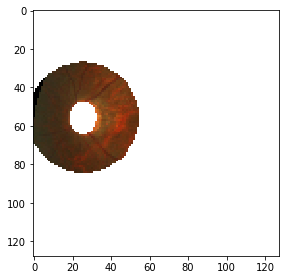

In [12]:
imshow(X_test[90]) # showing image
plt.show()

243


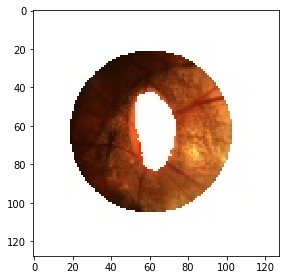

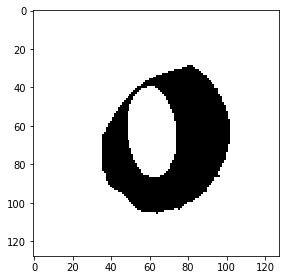

In [33]:
# Ploting Some Random Images
# image_x = 658
image_x = random.randint(0, len(train_ids))
print(image_x)
imshow(X_train[image_x]) # showing image
plt.show()
imshow(np.squeeze(Y_train[image_x])) # show coresponding mask
plt.show()


In [34]:
print(train_ids[image_x])

P0185.jpg


Build the Model (Creating Neural Network)

In [35]:
# Build the Model
inputs = tf.keras.layers.Input((img_width, img_hight, img_channels)) # Input Layer
float_Values = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # converting each value into flot for Neural Network
# Contraction path (going down)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(float_Values)
c1 = tf.keras.layers.Dropout(0.1)(c1) # dropout of 10%
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1) # creating new Layer
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)  # MaxPolling layer

c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout((0.2))(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

Up Scallig

In [36]:
#Expensive Path (Up Scalling)
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)##
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)##
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (2,2), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (2,2), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
# Output layer
outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(c9)

Compiling Model

In [37]:
# Compiling Model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')#, matrices=['accuracy'])  #optimize contais  Back propagation

Model Summary

In [6]:
# model.summary()

ModelCheckpoints and Callbacks

In [38]:
# ModelCheckpoints
checkPointer = tf.keras.callbacks.ModelCheckpoint('PPAExtractionModel.h5', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkPointer
]
''' Following Command is used to Open Tensorboard into Browser'''
"""  
tensorboard --logdir=logs/ --host localhost --port 8088
"""


'  \ntensorboard --logdir=logs/ --host localhost --port 8088\n'

Fitting the Model 

In [39]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=35, callbacks=callbacks)#

Train on 279 samples, validate on 32 samples
Epoch 1/35
272/279 [============================>.] - ETA: 0s - loss: 0.2429
Epoch 00001: val_loss improved from inf to 0.18654, saving model to PPAExtractionModel.h5
279/279 [==============================] - 38s 137ms/sample - loss: 0.2392 - val_loss: 0.1865
Epoch 2/35
272/279 [============================>.] - ETA: 0s - loss: 0.1376
Epoch 00002: val_loss improved from 0.18654 to 0.15103, saving model to PPAExtractionModel.h5
279/279 [==============================] - 37s 132ms/sample - loss: 0.1366 - val_loss: 0.1510
Epoch 3/35
272/279 [============================>.] - ETA: 0s - loss: 0.1123
Epoch 00003: val_loss improved from 0.15103 to 0.12865, saving model to PPAExtractionModel.h5
279/279 [==============================] - 36s 127ms/sample - loss: 0.1115 - val_loss: 0.1287
Epoch 4/35
272/279 [============================>.] - ETA: 0s - loss: 0.0961
Epoch 00004: val_loss improved from 0.12865 to 0.12737, saving model to PPAExtractionMo

#### Validation (Testing)

In [40]:
idx = random.randint(0, len(X_train))

# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# preds_test = model.predict(X_test, verbose=1)
predected_valid = model.predict(X_test[:int(X_test.shape[0]*0.9)], verbose=1)
preds_valid_t = (predected_valid > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)


360/360 [==============================] - 9s 25ms/sample


Actual Fundus Image:


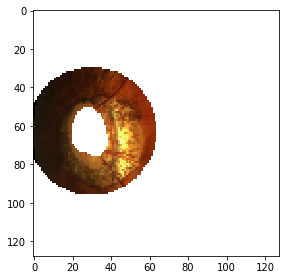

Predicted Optic Disk:


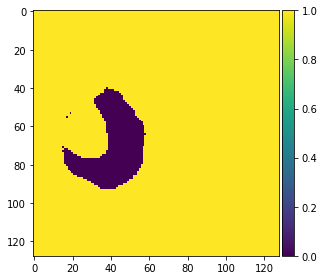

In [78]:
# perform a sanity check on some random training samples
ix = random.randint(0, len(preds_valid_t))
print('Actual Fundus Image:')
imshow(X_test[ix])
plt.show()
print('Predicted Optic Disk:')
imshow(np.squeeze(preds_valid_t[ix]))
plt.show()

In [79]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
model.save('PPAModel/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: PPAModel/my_model/assets


In [80]:
nmodel = tf.keras.models.load_model('PPAModel/my_model')

In [81]:
idx = random.randint(0, len(X_train))

# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# preds_test = model.predict(X_test, verbose=1)
predected_valid = nmodel.predict(X_test[:int(X_test.shape[0]*0.9)], verbose=1)
preds_valid_t = (predected_valid > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)


360/360 [==============================] - 10s 27ms/sample


Actual Fundus Image:


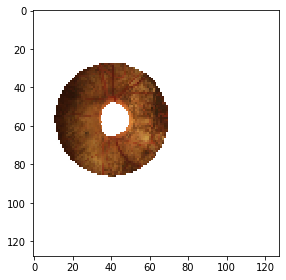

Predicted Optic Disk:


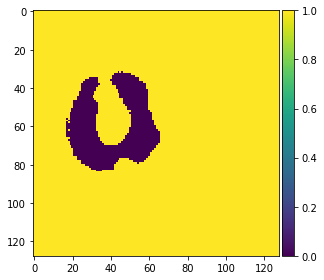

In [84]:
# perform a sanity check on some random training samples
#ix = random.randint(0, len(preds_valid_t))
ix=103
print('Actual Fundus Image:')
imshow(X_test[ix])
plt.show()
print('Predicted Optic Disk:')
imshow(np.squeeze(preds_valid_t[ix]))
plt.show()

## Extracting PPA

In [3]:
import cv2
import os
import matplotlib as plt

In [4]:
train_path = next(os.walk('fundus/'))[2]
train_ids = sorted(train_path)
# train_ids = train_ids[317:]
# train_ids = ['P0166.jpg','P0200.jpg','P0130.jpg']
print(train_ids)

['H0001.jpg', 'H0002.jpg', 'H0003.jpg', 'H0004.jpg', 'H0005.jpg', 'H0006.jpg', 'H0011.jpg', 'H0012.jpg', 'H0015.jpg', 'H0017.jpg', 'H0018.jpg', 'H0019.jpg', 'H0020.jpg', 'H0021.jpg', 'H0022.jpg', 'H0023.jpg', 'H0026.jpg', 'N0004.jpg', 'N0005.jpg', 'N0006.jpg', 'N0007.jpg', 'N0008.jpg', 'N0009.jpg', 'N0011.jpg', 'N0012.jpg', 'N0018.jpg', 'N0020.jpg', 'N0021.jpg', 'N0023.jpg', 'N0029.jpg', 'N0035.jpg', 'N0038.jpg', 'N0040.jpg', 'N0041.jpg', 'N0044.jpg', 'N0045.jpg', 'N0048.jpg', 'N0049.jpg', 'N0050.jpg', 'N0051.jpg', 'N0054.jpg', 'N0058.jpg', 'N0059.jpg', 'N0062.jpg', 'N0063.jpg', 'N0066.jpg', 'N0067.jpg', 'N0068.jpg', 'N0072.jpg', 'N0073.jpg', 'N0075.jpg', 'N0077.jpg', 'N0078.jpg', 'N0080.jpg', 'N0081.jpg', 'N0086.jpg', 'N0087.jpg', 'N0089.jpg', 'N0090.jpg', 'N0091.jpg', 'N0094.jpg', 'N0095.jpg', 'N0096.jpg', 'N0097.jpg', 'N0100.jpg', 'N0101.jpg', 'N0102.jpg', 'N0103.jpg', 'N0104.jpg', 'N0105.jpg', 'N0106.jpg', 'N0107.jpg', 'N0112.jpg', 'N0114.jpg', 'N0115.jpg', 'N0116.jpg', 'N0117.jpg'

In [6]:
path = 'PPA_images'
for filename in train_ids:
    mId = filename.split('.')[0]
    img = cv2.imread('masks/'+mId+'.bmp',0)
#     img = cv2.resize(img1, (400,400))
    ret,thresh = cv2.threshold(img,120,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    cnt = contours[0]
    M = cv2.moments(cnt)
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    radius += 11
    for i in range(1,110):
        img = cv2.circle(img,center,radius-i,(0,255,0),85)
    # print(radius)
    img2 = cv2.imread('fundus/'+filename,0)
    fimg = cv2.bitwise_or(img2,img)
    cv2.imwrite(os.path.join(path ,mId+'.jpg'), fimg)
# cv2.imshow('detected circles',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

KeyboardInterrupt: 